## НИУ ВШЭ НН. Факультет ИМиКН. Методы анализа данных. Charge de cours: В. А. Калягин
#### **Домашнее задание 2:** алгоритмы кластерного анализа. **Вариант 14**. Выполнил: **Игорь Рухович**

### Импортируем необходимые библиотеки

In [209]:
from matplotlib import pyplot as plt
from mst_clustering import MSTClustering
import networkx as nx
from networkx.algorithms.community import modularity
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
import seaborn as sns

### Код для чтения данных + общие переменные

In [19]:
data_path = "../data/xls/"
filename = lambda dtype, number: f"{dtype}/{dtype.upper()}_4_{number}.xlsx"
variants = range(1, 16)
dtypes = ["x", "y"]
my_variant = 14
random_state = 123

def read_specific_variant(dtype: str, number: int) -> pd.DataFrame:
    if dtype not in dtypes:
        raise RuntimeError("Wrong dtype")
    if number not in variants:
        raise RuntimeError("Wrong variant number")
    return pd.read_excel(data_path + filename(dtype, number), header=None)

## Данные. Первичная обработка.
### **0.1 Рассмотрим данные**
Рассмотрим первые строчки датасетов:

In [20]:
df = {}

df[dtypes[0]] = read_specific_variant(dtypes[0], my_variant)
df["x"].head()

,0,1,2,3
0,5.092168,1.034724,7.080165,-1.987996
1,4.846424,0.968371,6.787735,-1.941311
2,5.297292,1.205368,6.978480,-1.681188
3,3.729736,0.846779,4.919136,-1.189400
4,5.003340,1.094723,6.722511,-1.719171


In [22]:
df[dtypes[1]] = read_specific_variant(dtypes[1], my_variant)
df["y"].head()

,0,1,2,3
0,0.906940,1.006914,0.963778,0.824834
1,2.029085,0.799312,1.623610,0.952911
2,1.978421,1.102946,1.458704,0.978444
3,2.275134,0.829438,1.964464,1.040498
4,1.276684,0.056152,-0.198731,1.130742


Видим, что в обоих случаях мы имеем дело с векторами действительных чисел размерности 4.

Соберём некоторые статистики: среднее, стандартное отклонение и каждый 25-й процентиль:

In [23]:
df["x"].describe()

,0,1,2,3
count,200.000000,200.000000,200.000000,200.000000
mean,2.999880,0.978973,3.062841,-0.062961
std,2.665400,1.190919,2.636290,1.659201
min,-1.770611,-1.098890,-1.686545,-3.001601
25%,0.967169,0.094967,1.037855,-1.337723
50%,3.043348,1.013192,3.001980,-0.003096
75%,5.053307,1.939336,5.064147,1.147939
max,7.684823,3.085918,8.097899,3.110166


In [24]:
df["y"].describe()

,0,1,2,3
count,200.000000,200.000000,200.000000,200.000000
mean,1.384176,0.678902,1.068702,0.975327
std,0.514553,0.497740,0.875862,0.148078
min,0.627841,-0.832312,-0.307301,0.543181
25%,0.942615,0.177061,0.076568,0.894277
50%,1.121562,0.919683,1.059251,0.978145
75%,1.967040,1.036559,1.925251,1.050821
max,2.275134,1.349070,2.520664,1.482438


Оба набора данных состоят из 200 действительных векторов. По собранным статистикам зависимости между наборами или колонками не прослеживаются.

Чтобы лучше понять устройство данных, построим гистограммы распределения всех прихнаков, а так же их попарные распределения.
**Сверху** распределения **набора X**, а **снизу** - **набора Y**.

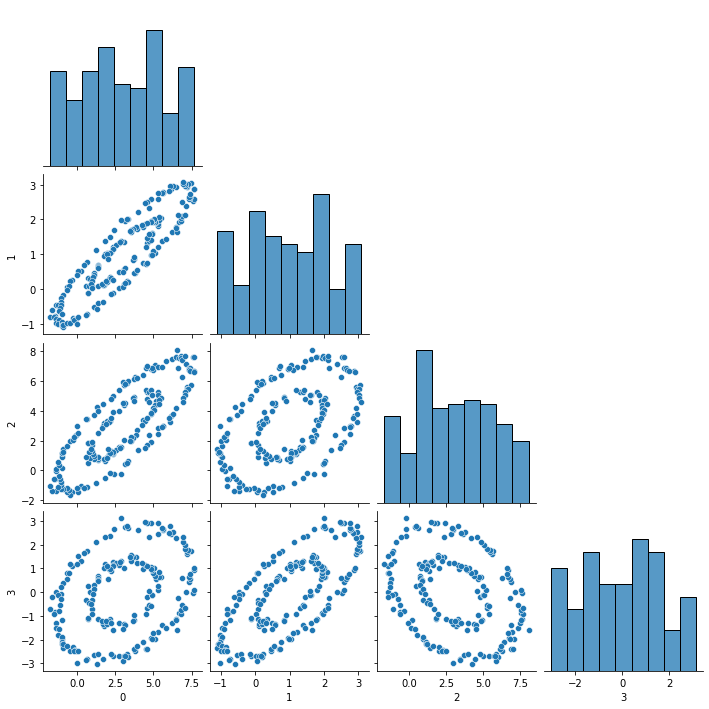

In [45]:
sns.pairplot(df["x"], corner=True)

В первом наборе данных распределение признаков по отдельности ни о чем нам не говорит, но можно заметить схожесть гистограмм разных признаков. 3 из 4 распределений имеют по 4 пика на тех же местах, значения плотно сгруппированы в узких диапазонах. В то же время, попарные распределения формируют очень интересную картину - мы видим, что данные в каждом попарном распределении представляют собой два эллипса с шумом, вписанные друг в друга. Можем сделать вывод, что данные - это две двумерных окружности (или эллипса) с общим центром в 4-мерном пространстве. **Есть вероятность, что этот набор возможно вписать в 2 координаты** без значительных потерь.

Проверим на 3-мерном рисунке:

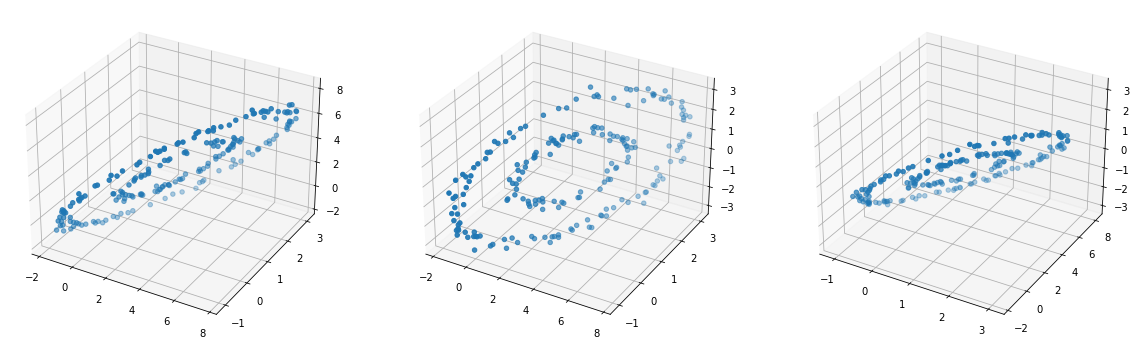

In [38]:
fig, axs = plt.subplots(1, 3, subplot_kw=dict(projection='3d'))
fig.set_size_inches(20,10)

axs[0].scatter(df["x"][0], df["x"][1], df["x"][2])
axs[1].scatter(df["x"][0], df["x"][1], df["x"][3])
axs[2].scatter(df["x"][1], df["x"][2], df["x"][3])

Проверим наше предположение с помощью сингулярного разложения:

In [60]:
u, s, vt = np.linalg.svd(df["x"], full_matrices=False)
print(f"Сингулярные числа матрицы:\n{s.round(4)}")
tmp_s = np.append(s, 0)
print(f"Абсолютная погрешность аппроксимации в спектральной матричной норме:\n{tmp_s[1:].round(4)}")
abs_errors_f = (tmp_s**2)[::-1].cumsum()[::-1][1:]
print(f"Абсолютная погрешность аппроксимации в норме Фробениуса:\n{abs_errors_f.round(4)}")
print(f"Относительная погрешность аппроксимации в норме Фробениуса, %:\n{(abs_errors_f/(tmp_s**2).sum()*100).round(4)}")

Сингулярные числа матрицы:
[80.8877 30.8643  0.      0.    ]
Абсолютная погрешность аппроксимации в спектральной матричной норме:
[30.8643  0.      0.      0.    ]
Абсолютная погрешность аппроксимации в норме Фробениуса:
[952.6072   0.       0.       0.    ]
Относительная погрешность аппроксимации в норме Фробениуса, %:
[12.7092  0.      0.      0.    ]


Действительно, матрица **имеет ровно 2 ненулевых сингулярных числа**, а значит данные можно поместить в Евклидово пространство размерности 2 без потерь! (но мы в работе, разумеется, делать этого не будем)

Перейдём ко второму набору:

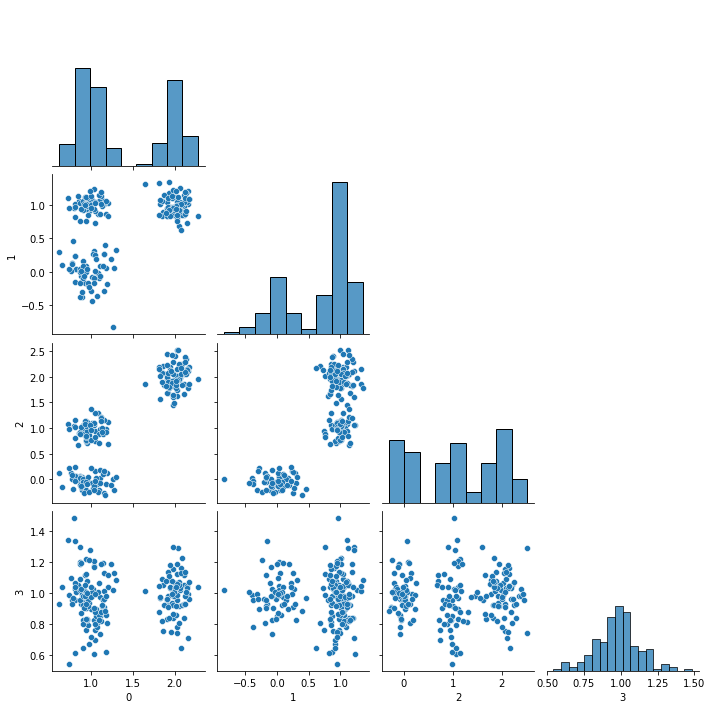

In [46]:
sns.pairplot(df["y"], corner=True)

По одиночным распределениям видим, что признаки из набора похожи на одно (признак 3) или несколько (признаки 0, 1) нормальных распределений. Попарные распределения явно делят данные на "плотные" множества, с похожим на нормальное с шумом распределение.

Посмотрим на трехмерные картинки:

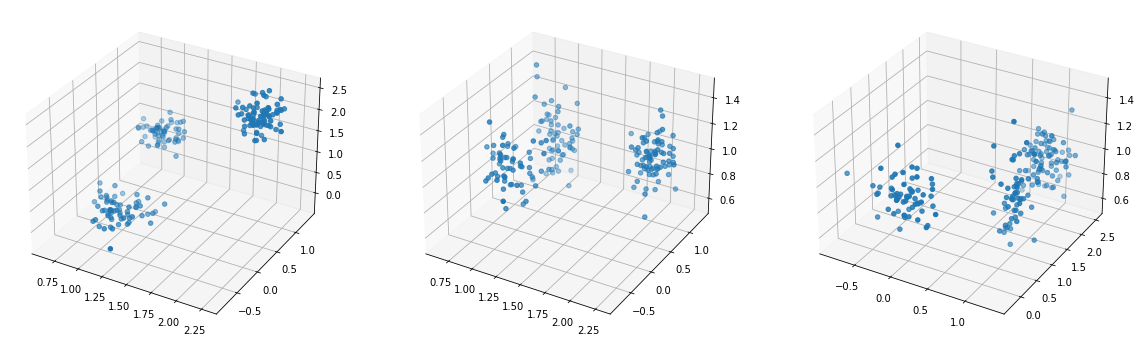

In [39]:
fig, axs = plt.subplots(1, 3, subplot_kw=dict(projection='3d'))
fig.set_size_inches(20,10)

axs[0].scatter(df["y"][0], df["y"][1], df["y"][2])
axs[1].scatter(df["y"][0], df["y"][1], df["y"][3])
axs[2].scatter(df["y"][1], df["y"][2], df["y"][3])

"Кучная" структура сохраняется, видим 3 разделяемых подмножества.

Снова применим сингулярное разложение:

In [59]:
u, s, vt = np.linalg.svd(df["y"], full_matrices=False)
print(f"Сингулярные числа матрицы:\n{s.round(4)}")
tmp_s = np.append(s, 0)
print(f"Абсолютная погрешность аппроксимации в спектральной матричной норме:\n{tmp_s[1:].round(4)}")
abs_errors_f = (tmp_s**2)[::-1].cumsum()[::-1][1:]
print(f"Абсолютная погрешность аппроксимации в норме Фробениуса:\n{abs_errors_f.round(4)}")
print(f"Относительная погрешность аппроксимации в норме Фробениуса, %:\n{(abs_errors_f/(tmp_s**2).sum()*100).round(4)}")

Сингулярные числа матрицы:
[32.5016  8.4099  4.6414  2.1061]
Абсолютная погрешность аппроксимации в спектральной матричной норме:
[8.4099 4.6414 2.1061 0.    ]
Абсолютная погрешность аппроксимации в норме Фробениуса:
[96.7043 25.9782  4.4356  0.    ]
Относительная погрешность аппроксимации в норме Фробениуса, %:
[8.3868 2.253  0.3847 0.    ]


Видим, что данные без больших потерь возможно поместить в Евклидово пространство размерности 2 и 3, но сохраним в данной работе полноценную структуру.

### **0.2 Подготовка данных**
В качестве дистанции выберем Евклидово расстояние между точками, поскольку на обеих картинках выше мы используем Евклидову метрику и уже видим хорошую кластерную структуру. Нет смысла усложнять этот шаг. Матрицу близости (adjacency matrix) возьмём как матрицу расстояний, вычтенную из её наибольшего значения.

In [64]:
dist_x = distance_matrix(df["x"], df["x"], p=2)
adj_x = dist_x.max() - dist_x
adj_x

array([[13.37497493, 12.98447807, 12.95584968, ..., 12.56958097,
        13.07251206, 12.66696944],
       [12.98447807, 13.37497493, 12.77206687, ..., 12.74660732,
        13.2822014 , 12.75819323],
       [12.95584968, 12.77206687, 13.37497493, ..., 12.19863341,
        12.81294539, 12.26975961],
       ...,
       [12.56958097, 12.74660732, 12.19863341, ..., 13.37497493,
        12.74654112, 13.20472724],
       [13.07251206, 13.2822014 , 12.81294539, ..., 12.74654112,
        13.37497493, 12.78326362],
       [12.66696944, 12.75819323, 12.26975961, ..., 13.20472724,
        12.78326362, 13.37497493]])

In [68]:
dist_y = distance_matrix(df["y"], df["y"], p=2)
adj_y = dist_y.max() - dist_y
adj_y

array([[3.29791481, 1.97349415, 2.1038289 , ..., 3.1387171 , 1.96430166,
        1.47992442],
       [1.97349415, 3.29791481, 2.94776274, ..., 2.04471137, 3.02423831,
        2.42449095],
       [2.1038289 , 2.94776274, 3.29791481, ..., 2.16211617, 2.85622037,
        2.32885691],
       ...,
       [3.1387171 , 2.04471137, 2.16211617, ..., 3.29791481, 2.00983162,
        1.51321064],
       [1.96430166, 3.02423831, 2.85622037, ..., 2.00983162, 3.29791481,
        2.62051559],
       [1.47992442, 2.42449095, 2.32885691, ..., 1.51321064, 2.62051559,
        3.29791481]])

В таком виде матрицу расстояний можно также назвать матрицей смежности для полного графа, вершинами которого являются точки из набора данных, а расстояние между точками определяет вес ребра. Поскольку все точки имеют конечные координаты, существует ребро между любой парой точек, а значит граф полный. В координатах $i, i$ находятся нули - граф не содержит петель. Евклидово расстояние коммутативно - граф неориентированный:

In [71]:
dist_x

array([[0.        , 0.39049687, 0.41912526, ..., 0.80539397, 0.30246287,
        0.70800549],
       [0.39049687, 0.        , 0.60290806, ..., 0.62836761, 0.09277354,
        0.61678171],
       [0.41912526, 0.60290806, 0.        , ..., 1.17634152, 0.56202955,
        1.10521532],
       ...,
       [0.80539397, 0.62836761, 1.17634152, ..., 0.        , 0.62843381,
        0.17024769],
       [0.30246287, 0.09277354, 0.56202955, ..., 0.62843381, 0.        ,
        0.59171132],
       [0.70800549, 0.61678171, 1.10521532, ..., 0.17024769, 0.59171132,
        0.        ]])

Создадим графовые структуры с помощью модуля `networkx`:

In [248]:
def create_graph(distances):
    G = nx.Graph()
    for i in range(distances.shape[0]):
        for j in range(distances.shape[1]):
            G.add_edge(i, j, weight=distances[i, j])
    return G

G_x = create_graph(adj_x)
G_y = create_graph(adj_y)

### **1. Кластеризация на 2 кластера**
Попробуем использовать некоторые алгоритмы кластеризации над данными.

Будем отдельно хранить метки кластеров, для дальнейших подсчетов:

In [147]:
labels = {"x": {}, "y": {}}

#### **1.1 Находим разбиение наборов**
#### **K-means clustering**

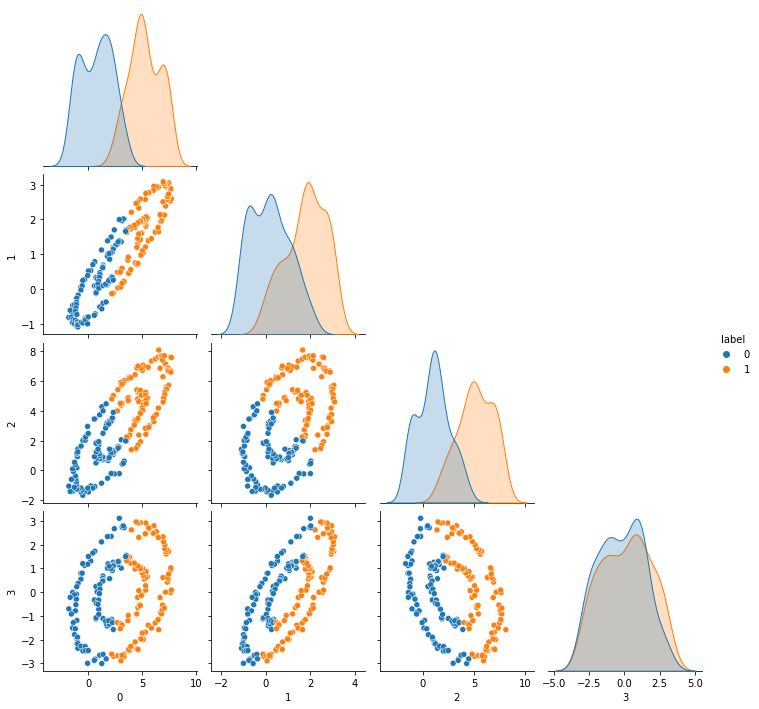

In [148]:
kmeans = KMeans(n_clusters=2, init="k-means++", n_init="auto",
                random_state=random_state, algorithm="lloyd").fit(df["x"])
labels["x"]["kmeans"] = kmeans.labels_

plotting_df = df["x"].copy()
plotting_df["label"] = labels["x"]["kmeans"]
sns.pairplot(plotting_df, corner=True, hue="label")

Мы использовали оптимизированный алгоритм `greedy k-means++`. Его преимущество в том, что начальные центроиды выбираются с помощью специального алгоритма, основанного на инерции. Таким образом, нам не требуется делать много итераци, чтобы получить хороший результат.

Тем не менее видим, что k-means со своей задачей на этом наборе справился плохо - что ожидаемо, поскольку алгоритм основан на близости точек, а мы имеем дело с вписанными эллипсами.

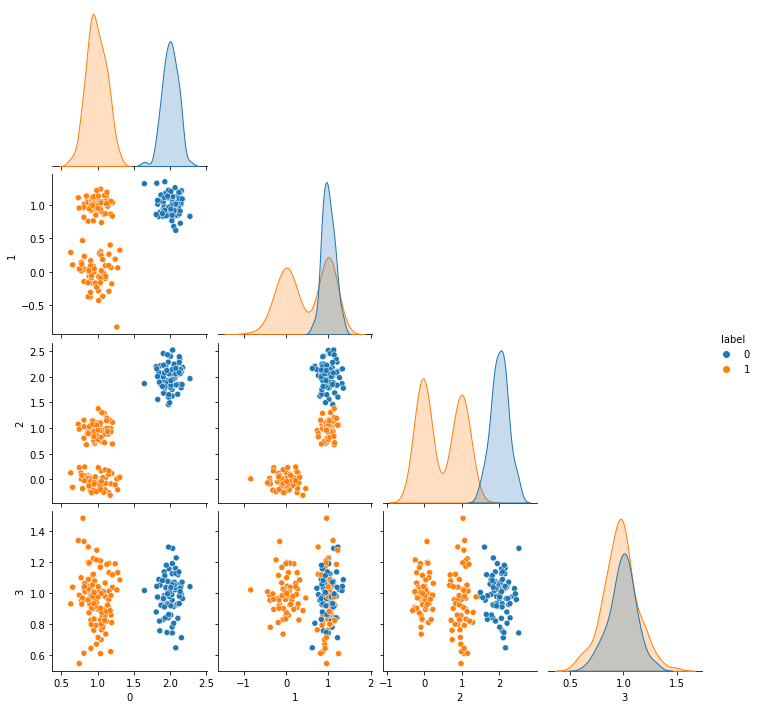

In [149]:
kmeans = KMeans(n_clusters=2, init="k-means++", n_init="auto",
                random_state=random_state, algorithm="lloyd").fit(df["y"])
labels["y"]["kmeans"] = kmeans.labels_

plotting_df = df["y"].copy()
plotting_df["label"] = labels["y"]["kmeans"]
sns.pairplot(plotting_df, corner=True, hue="label")

Что касается второго набора данных - k-means показывает себя отлично. Он явно отделил одно из множеств точек в отдельный кластер (остальные смешаны, поскольку имеем 2 кластера)

#### **EM-алгоритм (Gaussian mixture)**

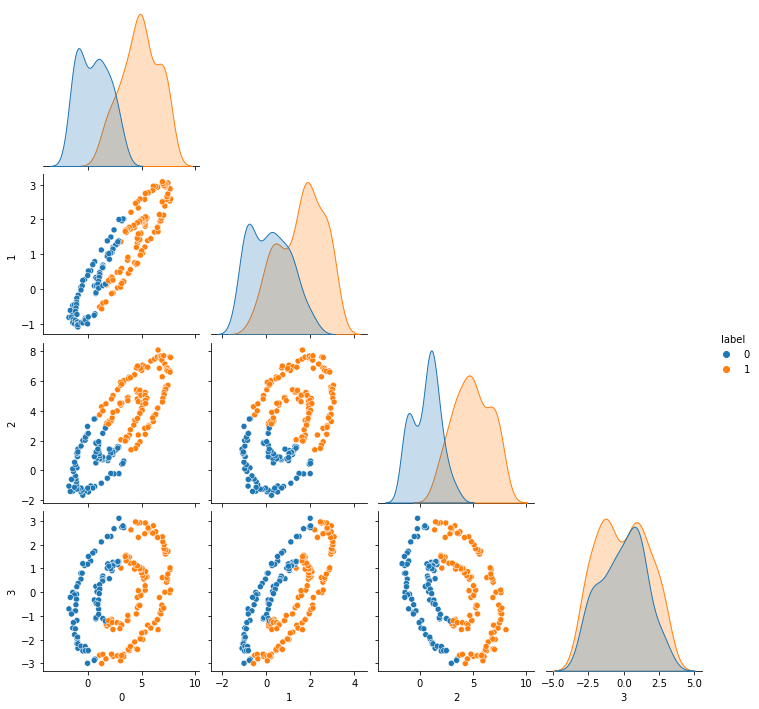

In [150]:
labels["x"]["em"] = GaussianMixture(n_components=2, init_params="k-means++",
                                    random_state=random_state).fit_predict(df["x"])

plotting_df = df["x"].copy()
plotting_df["label"] = labels["x"]["em"]
sns.pairplot(plotting_df, corner=True, hue="label")

EM-алгоритм справился с датасетом X не лучше k-means, что не удивительно, ведь алгоритмы довольно похожи. В качестве инициализации EM брали уже упомянутый `k-means++`, помогающий лучше выбрать стартовые значения.

Проверим этот алгоритм на Y:

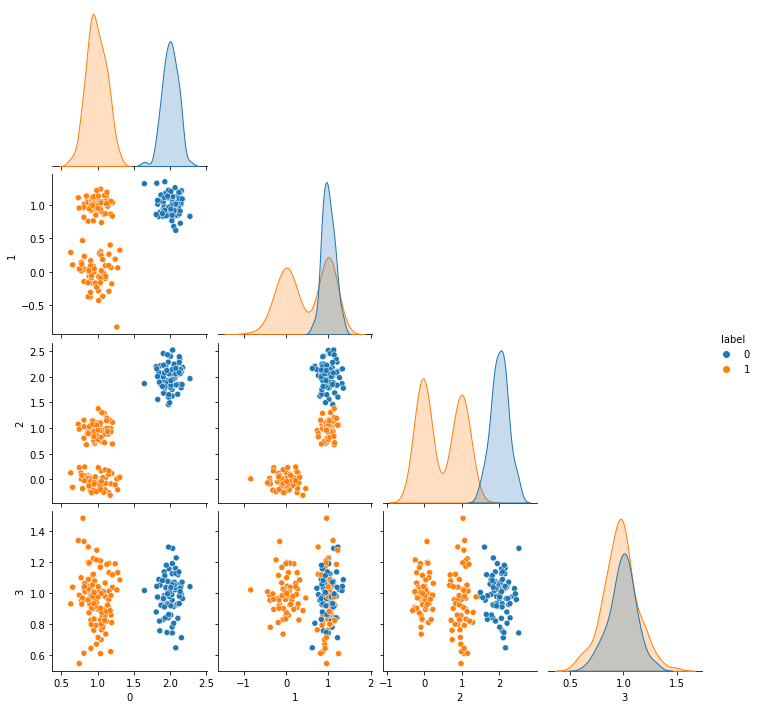

In [151]:
labels["y"]["em"] = GaussianMixture(n_components=2, init_params="k-means++",
                                    random_state=random_state).fit_predict(df["y"])

plotting_df = df["y"].copy()
plotting_df["label"] = labels["y"]["em"]
sns.pairplot(plotting_df, corner=True, hue="label")

На втором наборе EM-алгоритм тоже смог отделить один из кластеров и сработал очень похоже на k-means

#### **MST method**
Для MST алгоритма используется сторонняя реализация: https://github.com/jakevdp/mst_clustering

В параметрах данного алгоритма выбираем, сколько рёбер нам оставить (`cutoff=1` - нужно получить 2 кластера). В качестве дистанции в этой реализации используется Евклидово расстояние между точками.

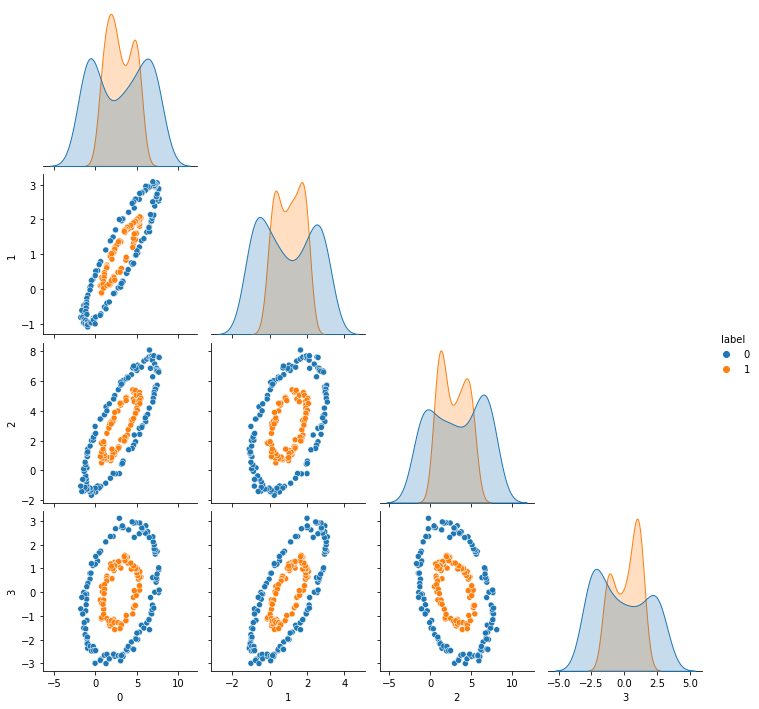

In [177]:
labels["x"]["mst"] = MSTClustering(cutoff=1, approximate=False).fit_predict(df["x"])

plotting_df = df["x"].copy()
plotting_df["label"] = labels["x"]["mst"]
sns.pairplot(plotting_df, corner=True, hue="label")

Как мы видим, алгоритм отлично справился с первым набором, четко разделив окружности. Попробуем на втором:

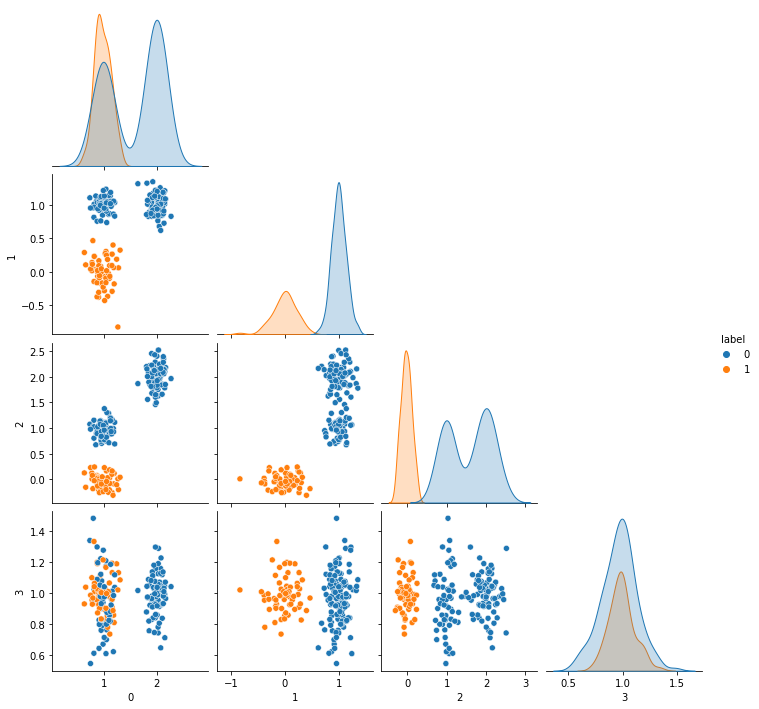

In [178]:
labels["y"]["mst"] = MSTClustering(cutoff=1, approximate=False).fit_predict(df["y"])

plotting_df = df["y"].copy()
plotting_df["label"] = labels["y"]["mst"]
sns.pairplot(plotting_df, corner=True, hue="label")

Как и предыдущие алгоритмы, MST нашёл среди данных "плотное" множество и выделил его в кластер - отлично!
#### **Spectral clustering**
Попробуем кластеризовать наборы с помощью спектрального алгоритма:

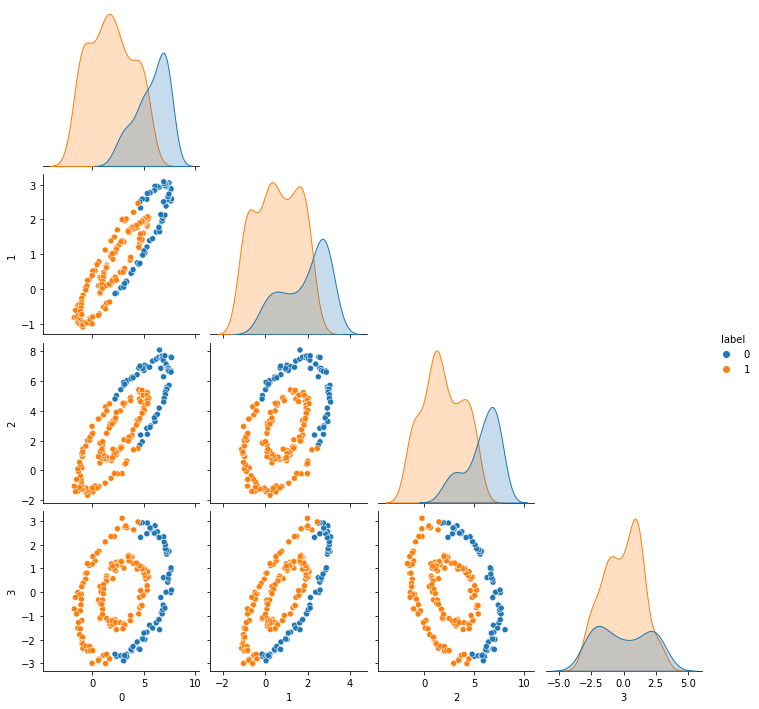

In [191]:
spectral = SpectralClustering(n_clusters=2, affinity="nearest_neighbors", random_state=random_state).fit(df["x"])
labels["x"]["spectral"] = spectral.labels_

plotting_df = df["x"].copy()
plotting_df["label"] = labels["x"]["spectral"]
sns.pairplot(plotting_df, corner=True, hue="label")

Ничего не получилось - и это не ожидаемо. Спектральный алгоритм должен хорошо работать на таких данных. Видим, что он не взял центральное кольцо в синий кластер, тем не менее, внешнее кольцо он выделил только наполовину.

Возможно, всё дело в избыточной размерности. Попробуем перед кластеризацией применить PCA и оставить 2 компоненты (знаем, что этот набор можно без потерь поместить в двумерное Евклидово пространство):

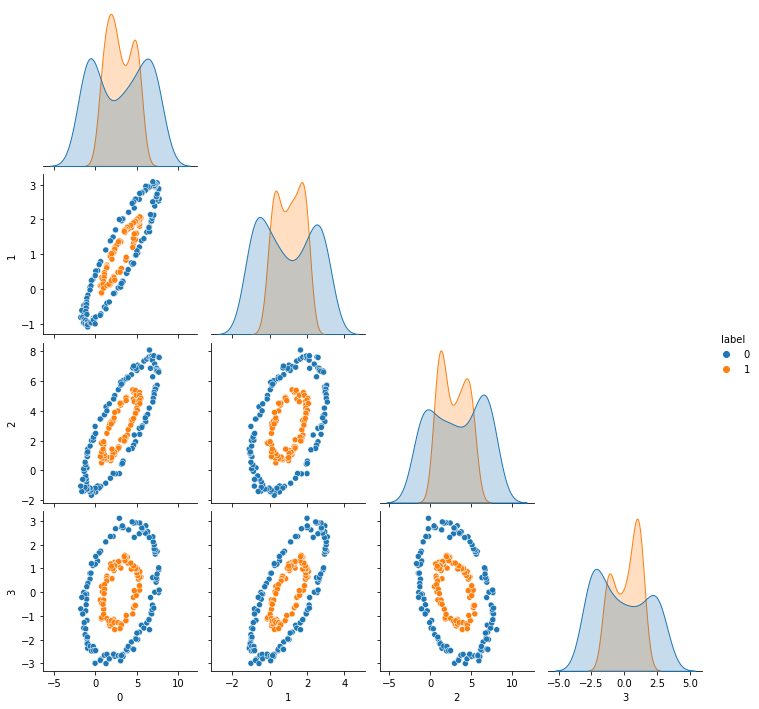

In [192]:
u, s, vt = np.linalg.svd(df["x"], full_matrices=False)
spectral = SpectralClustering(n_clusters=2, affinity="nearest_neighbors", random_state=random_state).fit(u[:,:2])
labels["x"]["spectral"] = spectral.labels_

plotting_df = df["x"].copy()
plotting_df["label"] = labels["x"]["spectral"]
sns.pairplot(plotting_df, corner=True, hue="label")

Да, действительно! При удалении линейных зависимостей в признаках спектральный алгоритм стал правильно выполнять кластеризацию!

Посмотрим на наборе Y:

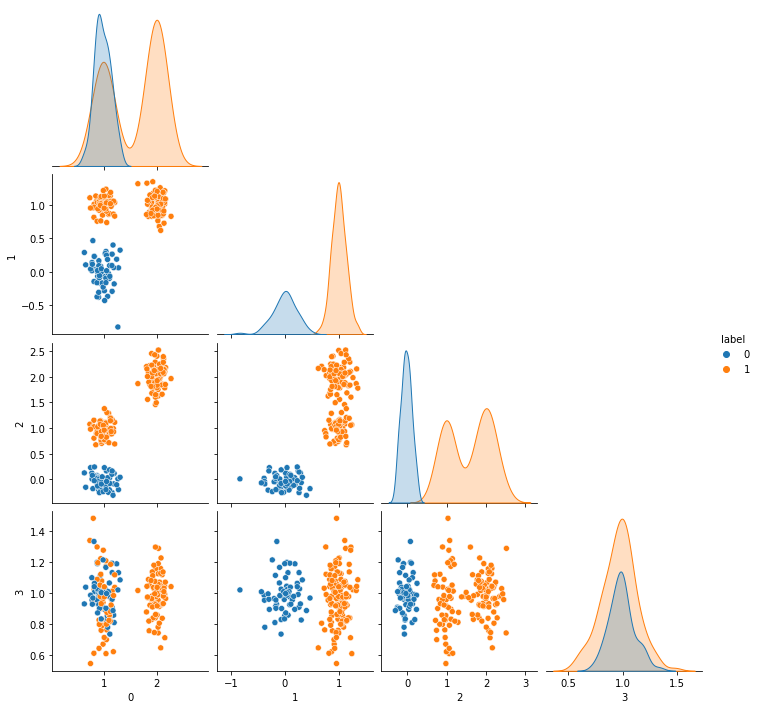

In [199]:
spectral = SpectralClustering(n_clusters=2, random_state=random_state).fit(df["y"])
labels["y"]["spectral"] = spectral.labels_

plotting_df = df["y"].copy()
plotting_df["label"] = labels["y"]["spectral"]
sns.pairplot(plotting_df, corner=True, hue="label")

Спектральный алгоритм справился с этой задачей. Один кластер выделен.

#### **1.2, 1.3 RAND index и модулярность**
RAND index - индекс похожести двух разбиений, похожий на метрику `accuracy`. Реализуем его подсчет самостоятельно:

In [154]:
def compute_rand_index(labels_x, labels_y):
    if labels_x.shape[0] != labels_y.shape[0]:
        raise RuntimeError("Shapes must be equal")
    ab, cd = 0, 0
    for i in range(labels_x.shape[0]):
        for j in range(i+1, labels_x.shape[0]):
            if labels_x[i] == labels_x[j]:
                if labels_y[i] == labels_y[j]:
                    ab += 1
                else:
                    cd += 1
            else:
                if labels_y[i] == labels_y[j]:
                    cd += 1
                else:
                    ab += 1
    
    return (ab) / (ab + cd)

In [238]:
print(f'RAND index для X, K-means и EM: \
{compute_rand_index(labels["x"]["kmeans"], labels["x"]["em"]):.3f}')
print(f'RAND index для Y, K-means и EM: \
{compute_rand_index(labels["y"]["kmeans"], labels["y"]["em"]):.3f}\n')

print(f'RAND index для X, K-means и MST: \
{compute_rand_index(labels["x"]["kmeans"], labels["x"]["mst"]):.3f}')
print(f'RAND index для Y, K-means и MST: \
{compute_rand_index(labels["y"]["kmeans"], labels["y"]["mst"]):.3f}\n')

print(f'RAND index для X, K-means и Spectral: \
{compute_rand_index(labels["x"]["kmeans"], labels["x"]["spectral"]):.3f}')
print(f'RAND index для Y, K-means и Spectral: \
{compute_rand_index(labels["y"]["kmeans"], labels["y"]["spectral"]):.3f}\n')

print(f'RAND index для X, EM и MST: \
{compute_rand_index(labels["x"]["em"], labels["x"]["mst"]):.3f}')
print(f'RAND index для Y, EM и MST: \
{compute_rand_index(labels["y"]["em"], labels["y"]["mst"]):.3f}\n')

print(f'RAND index для X, EM и Spectral: \
{compute_rand_index(labels["x"]["em"], labels["x"]["spectral"]):.3f}')
print(f'RAND index для Y, EM и Spectral: \
{compute_rand_index(labels["y"]["em"], labels["y"]["spectral"]):.3f}\n')

print(f'RAND index для X, MST и Spectral: \
{compute_rand_index(labels["x"]["mst"], labels["x"]["spectral"]):.3f}')
print(f'RAND index для Y, MST и Spectral: \
{compute_rand_index(labels["y"]["mst"], labels["y"]["spectral"]):.3f}\n')

RAND index для X, K-means и EM: 0.861
RAND index для Y, K-means и EM: 1.000

RAND index для X, K-means и MST: 0.502
RAND index для Y, K-means и MST: 0.586

RAND index для X, K-means и Spectral: 0.502
RAND index для Y, K-means и Spectral: 0.586

RAND index для X, EM и MST: 0.498
RAND index для Y, EM и MST: 0.586

RAND index для X, EM и Spectral: 0.498
RAND index для Y, EM и Spectral: 0.586

RAND index для X, MST и Spectral: 1.000
RAND index для Y, MST и Spectral: 1.000



Видим, как и ожадалось, что K-means и EM алгоритм дают похожие разбиения, а также MST и Спектральный алгоритм работают в данном случае идентично. Между собой разбиения, полученные этими алгоритмами похожи не так сильно.

Перейдём к модулярности. Будем рассчитывать её с помощью встроенного в модуль `networkx` функционала. Уже имеем графовые структуры на основе матриц близости в этом фреймворке. Посчитаем модулярности разбиений:

In [265]:
def get_lables(dtype, algo, n_clusters):
    if dtype not in dtypes:
        raise RuntimeError("Dtype must be x or y")
    if algo not in labels[dtype]:
        raise RuntimeError("Lables are not calculated yet")
    s0 = set(np.where(labels[dtype][algo]==0)[0])
    s1 = set(np.where(labels[dtype][algo]==1)[0])
    s2 = set(np.where(labels[dtype][algo]==2)[0])
    if n_clusters == 2:
        return [s0, s1]
    elif n_clusters == 3:
        return [s0, s1, s2]
    else:
        raise RuntimeError("n_clusters must be in [2, 3]")

In [266]:
print("X dataset:")
print(f'Modularity value for K-means clustering: \
{modularity(G_x, get_lables("x", "kmeans", 2)):.3f}')
print(f'Modularity value for EM clustering: \
{modularity(G_x, get_lables("x", "em", 2)):.3f}')
print(f'Modularity value for MST clustering: \
{modularity(G_x, get_lables("x", "mst", 2)):.3f}')
print(f'Modularity value for Spectral clustering: \
{modularity(G_x, get_lables("x", "spectral", 2)):.3f}')

print("\nY dataset:")
print(f'Modularity value for K-means clustering: \
{modularity(G_x, get_lables("y", "kmeans", 2)):.3f}')
print(f'Modularity value for EM clustering: \
{modularity(G_x, get_lables("y", "em", 2)):.3f}')
print(f'Modularity value for MST clustering: \
{modularity(G_x, get_lables("y", "mst", 2)):.3f}')
print(f'Modularity value for Spectral clustering: \
{modularity(G_x, get_lables("y", "spectral", 2)):.3f}')

X dataset:


NotAPartition: Graph with 200 nodes and 20100 edges is not a valid partition of the graph [{128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 142, 143, 145, 146, 74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127}, {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 75, 190, 192, 193, 194, 195, 196, 197, 198, 199}]

Модулярность показывает, что разбиения, сделанные K-means и EM лучше MST и Spectral для обоих наборов данных. В то же время мы видим, что, напротив, правильно кластеризовали первый набор только MST и Спектральный алгоритм. Что касается набора Y - все алгоритмы показали себя одинаково хорошо, хотя модулярность и не говорит об этом.

#### **1.4 Выводы**

Набор X, состоящий из двух необычно расположенных множеств, был правильно кластеризован алгоритмами MST и Спектральным (при понижении размерности). EM и K-means не нашли никакой интересной кластерной структуры.

В то же время набор Y, состоящий из 3-х плотно расположенных групп точек, был правильно кластеризован всеми алгоритмами - каждый правильно выделил по одному обособленному множеству.

Таким образом, MST-алгоритм объявляется победителем в данном эксперименте. Для Спектрального делаем вывод - алгоритм хорош, но нужно избавляться от линейной зависимости.

### **2. Кластеризация на 3 кластера**
Выполним все те же действия, но на этот раз будем искать в данных 3 кластера:

#### **2.1 Находим разбиение наборов**
#### **K-means clustering**

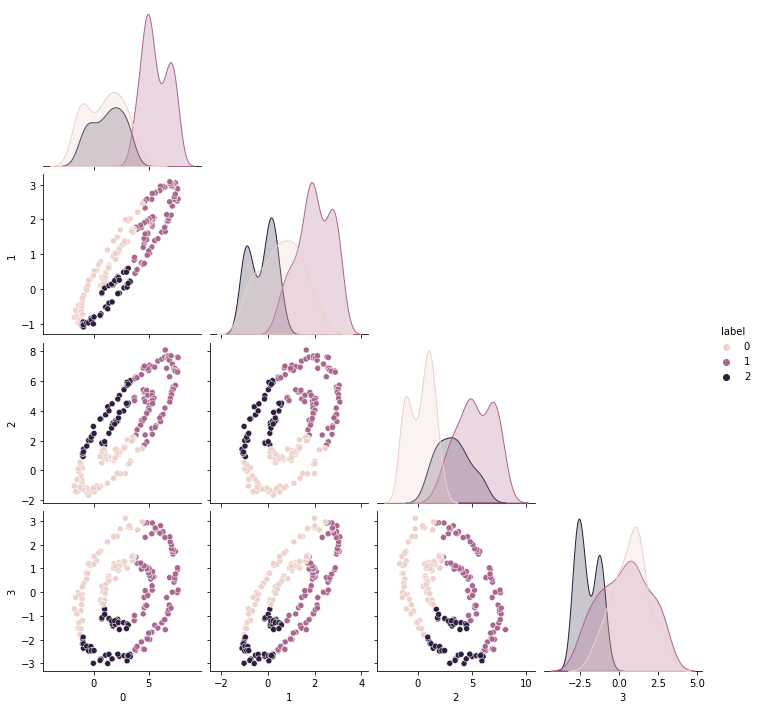

In [250]:
kmeans = KMeans(n_clusters=3, init="k-means++", n_init="auto",
                random_state=random_state, algorithm="lloyd").fit(df["x"])
labels["x"]["kmeans"] = kmeans.labels_

plotting_df = df["x"].copy()
plotting_df["label"] = labels["x"]["kmeans"]
sns.pairplot(plotting_df, corner=True, hue="label")

K-means снова не смог установить кластерную структуру в наборе X.

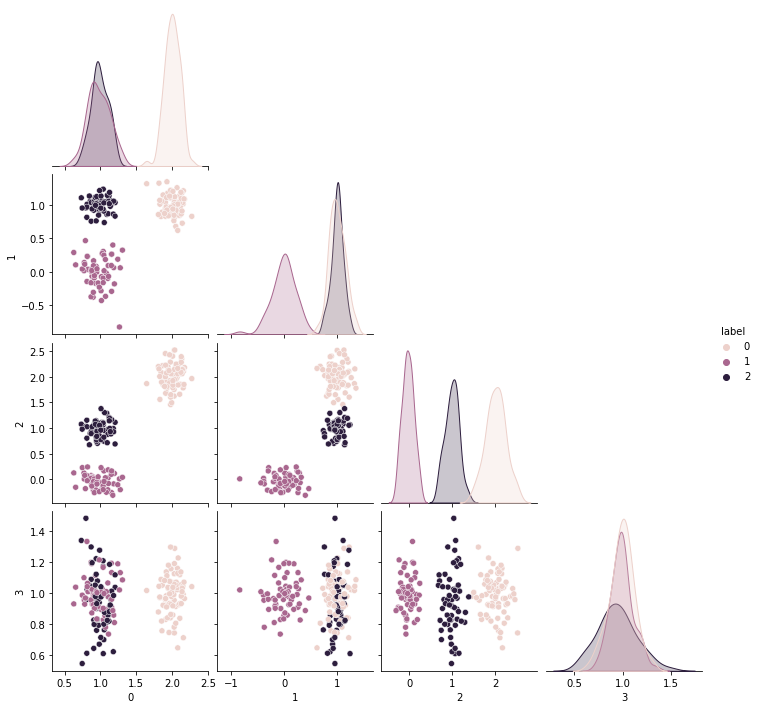

In [251]:
kmeans = KMeans(n_clusters=3, init="k-means++", n_init="auto",
                random_state=random_state, algorithm="lloyd").fit(df["y"])
labels["y"]["kmeans"] = kmeans.labels_

plotting_df = df["y"].copy()
plotting_df["label"] = labels["y"]["kmeans"]
sns.pairplot(plotting_df, corner=True, hue="label")

Набор Y разделился идеально!

#### **EM-алгоритм (Gaussian mixture)**

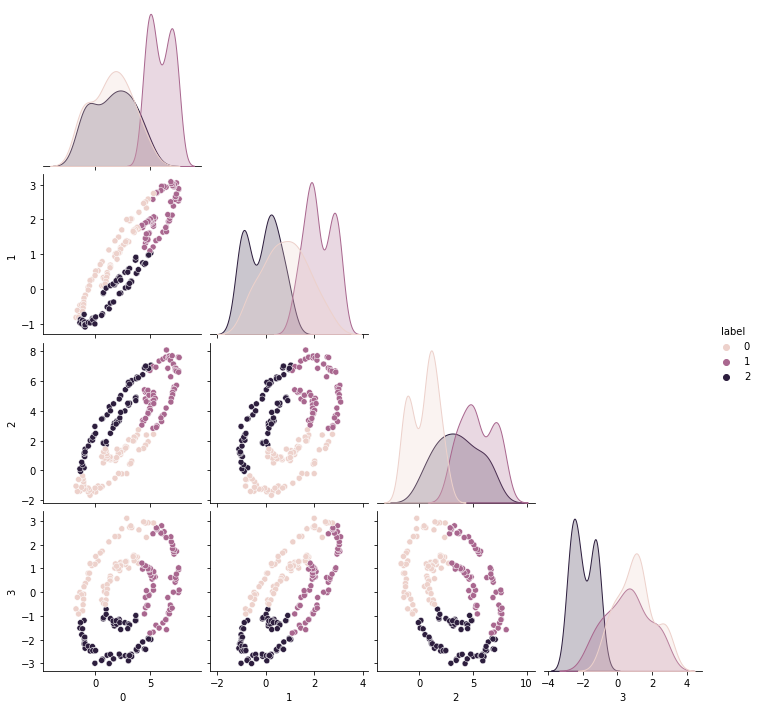

In [252]:
labels["x"]["em"] = GaussianMixture(n_components=3, init_params="k-means++",
                                    random_state=random_state).fit_predict(df["x"])

plotting_df = df["x"].copy()
plotting_df["label"] = labels["x"]["em"]
sns.pairplot(plotting_df, corner=True, hue="label")

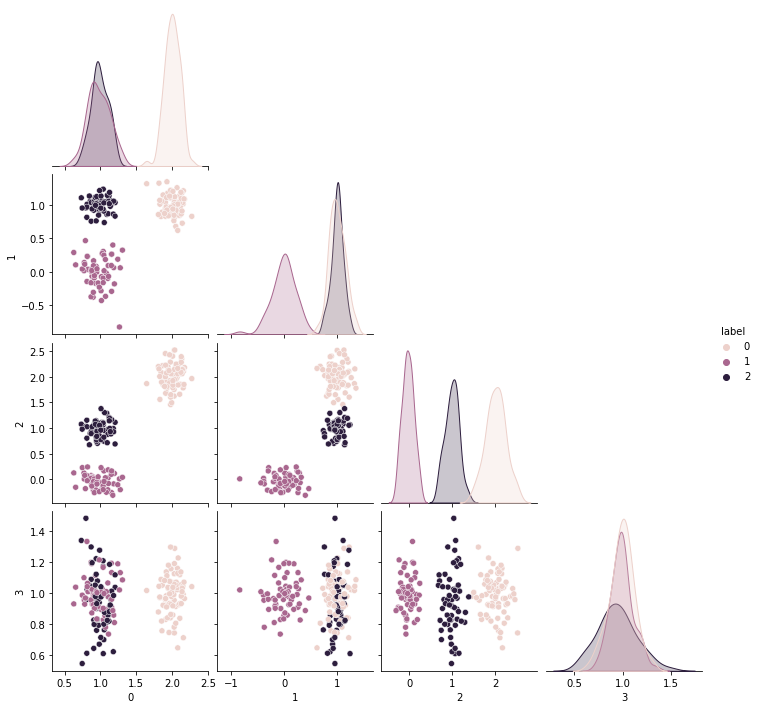

In [254]:
labels["y"]["em"] = GaussianMixture(n_components=3, init_params="k-means++",
                                    random_state=random_state).fit_predict(df["y"])

plotting_df = df["y"].copy()
plotting_df["label"] = labels["y"]["em"]
sns.pairplot(plotting_df, corner=True, hue="label")

Похожий алгоритм EM сработал совершенно аналогично. Визуально разбиения кажутся одинаковыми - точнее узнаем, когда сосчитаем метрики.

#### **MST method**
На этот раз ставим `cutoff=2` - нам необходимо 3 кластера, а значит 2 ребра

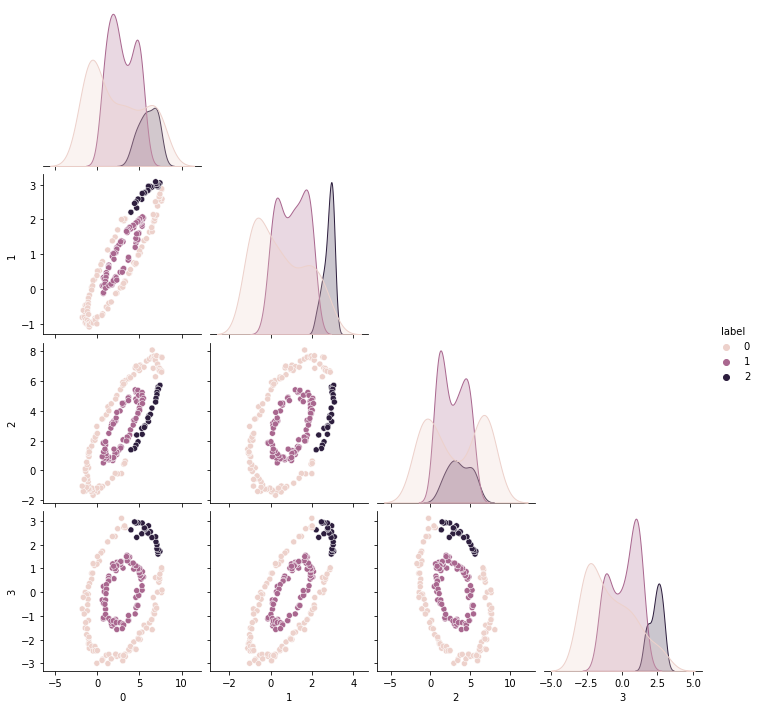

In [257]:
labels["x"]["mst"] = MSTClustering(cutoff=2, approximate=False).fit_predict(df["x"])

plotting_df = df["x"].copy()
plotting_df["label"] = labels["x"]["mst"]
sns.pairplot(plotting_df, corner=True, hue="label")

В двухкластерной структуре алгоритм правильно выделил кольца, но, из-за требования найти 3 кластера, ему пришлось оставить лишнюю связь, тем самым разбив внешнее кольцо на 2.

Смотрим на Y:

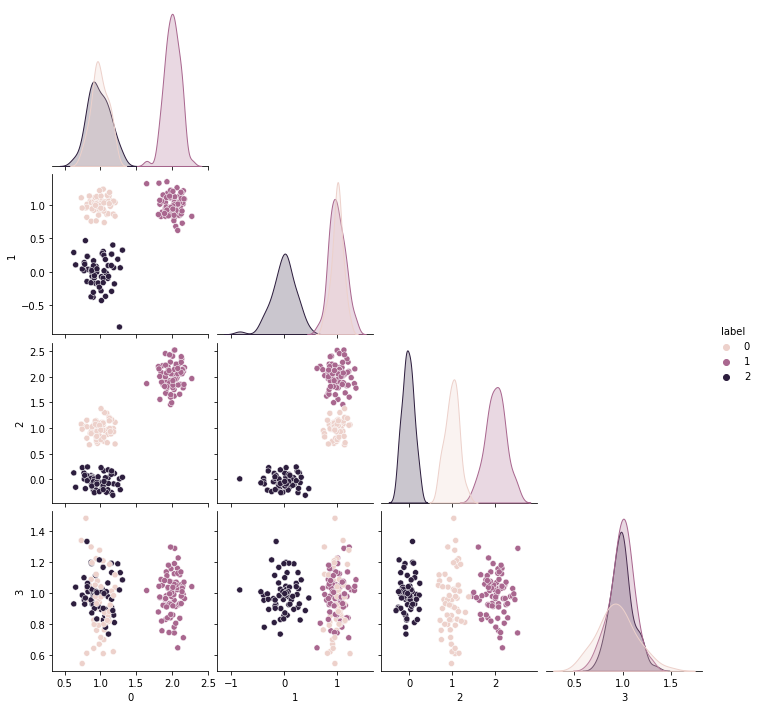

In [258]:
labels["y"]["mst"] = MSTClustering(cutoff=2, approximate=False).fit_predict(df["y"])

plotting_df = df["y"].copy()
plotting_df["label"] = labels["y"]["mst"]
sns.pairplot(plotting_df, corner=True, hue="label")

Идеально! С этим набором пока справляются все модели.

#### **Spectral clustering**

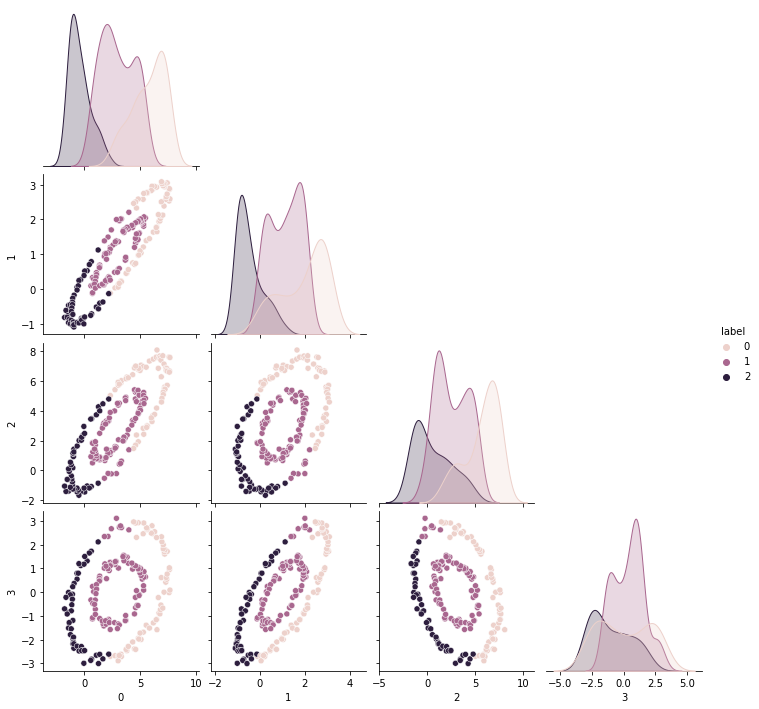

In [259]:
spectral = SpectralClustering(n_clusters=3, affinity="nearest_neighbors",
                              random_state=random_state).fit(df["x"])
labels["x"]["spectral"] = spectral.labels_

plotting_df = df["x"].copy()
plotting_df["label"] = labels["x"]["spectral"]
sns.pairplot(plotting_df, corner=True, hue="label")

Снова неудача - спектральный алгоритм не смог выделить внутреннее кольцо. Попробуем понизить размерность:

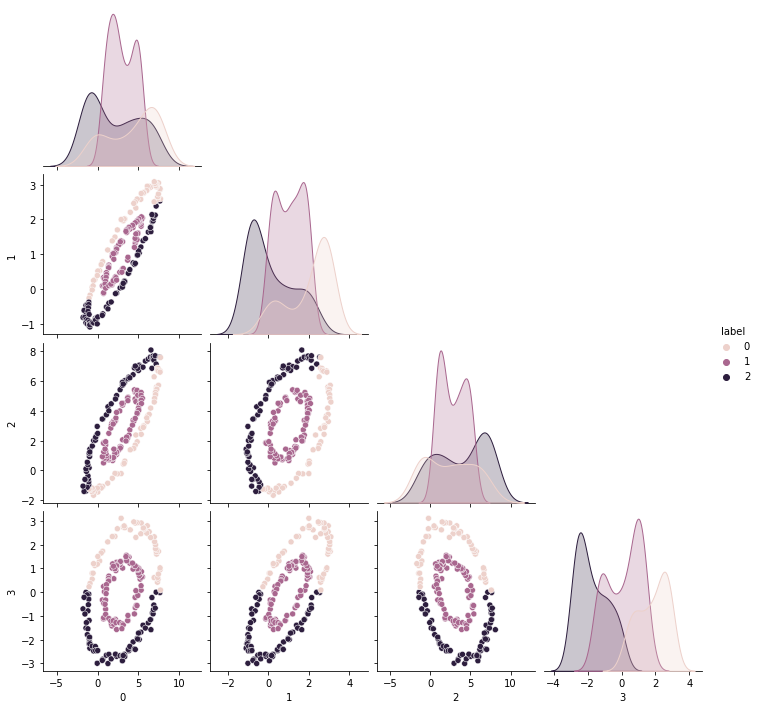

In [261]:
u, s, vt = np.linalg.svd(df["x"], full_matrices=False)
spectral = SpectralClustering(n_clusters=3, affinity="nearest_neighbors", random_state=random_state).fit(u[:,:2])
labels["x"]["spectral"] = spectral.labels_

plotting_df = df["x"].copy()
plotting_df["label"] = labels["x"]["spectral"]
sns.pairplot(plotting_df, corner=True, hue="label")

Здорово! Внутреннее кольцо найдено правильно, внешнее разбито на 2 равных части.

Перейдём к Y:

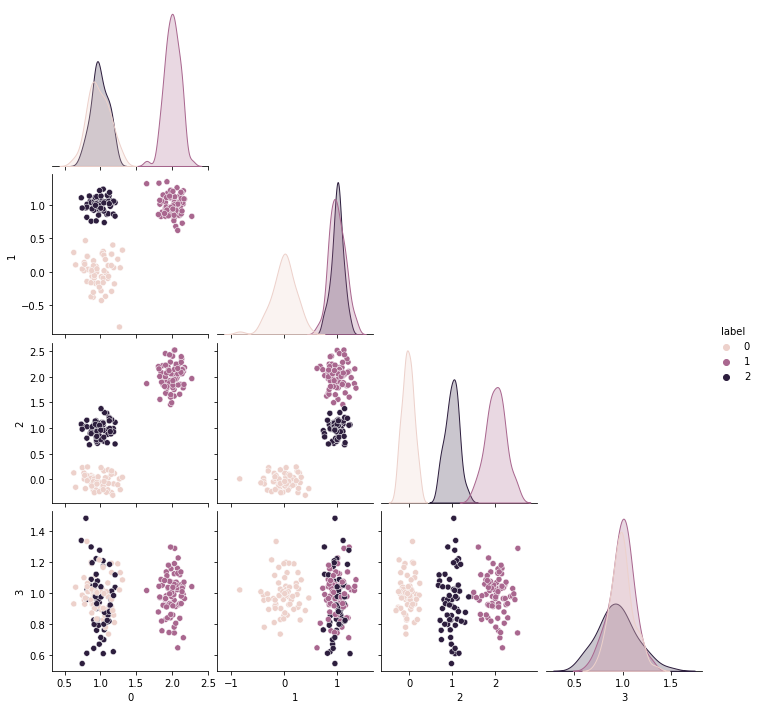

In [262]:
spectral = SpectralClustering(n_clusters=3, random_state=random_state).fit(df["y"])
labels["y"]["spectral"] = spectral.labels_

plotting_df = df["y"].copy()
plotting_df["label"] = labels["y"]["spectral"]
sns.pairplot(plotting_df, corner=True, hue="label")

Отлично! Кластеризация удалась.

#### **2.2, 2.3 RAND index и модулярность**
Для более точных выводов снова посчитаем метрики: 

In [263]:
print(f'RAND index для X, K-means и EM: \
{compute_rand_index(labels["x"]["kmeans"], labels["x"]["em"]):.3f}')
print(f'RAND index для Y, K-means и EM: \
{compute_rand_index(labels["y"]["kmeans"], labels["y"]["em"]):.3f}\n')

print(f'RAND index для X, K-means и MST: \
{compute_rand_index(labels["x"]["kmeans"], labels["x"]["mst"]):.3f}')
print(f'RAND index для Y, K-means и MST: \
{compute_rand_index(labels["y"]["kmeans"], labels["y"]["mst"]):.3f}\n')

print(f'RAND index для X, K-means и Spectral: \
{compute_rand_index(labels["x"]["kmeans"], labels["x"]["spectral"]):.3f}')
print(f'RAND index для Y, K-means и Spectral: \
{compute_rand_index(labels["y"]["kmeans"], labels["y"]["spectral"]):.3f}\n')

print(f'RAND index для X, EM и MST: \
{compute_rand_index(labels["x"]["em"], labels["x"]["mst"]):.3f}')
print(f'RAND index для Y, EM и MST: \
{compute_rand_index(labels["y"]["em"], labels["y"]["mst"]):.3f}\n')

print(f'RAND index для X, EM и Spectral: \
{compute_rand_index(labels["x"]["em"], labels["x"]["spectral"]):.3f}')
print(f'RAND index для Y, EM и Spectral: \
{compute_rand_index(labels["y"]["em"], labels["y"]["spectral"]):.3f}\n')

print(f'RAND index для X, MST и Spectral: \
{compute_rand_index(labels["x"]["mst"], labels["x"]["spectral"]):.3f}')
print(f'RAND index для Y, MST и Spectral: \
{compute_rand_index(labels["y"]["mst"], labels["y"]["spectral"]):.3f}\n')

RAND index для X, K-means и EM: 0.858
RAND index для Y, K-means и EM: 1.000

RAND index для X, K-means и MST: 0.531
RAND index для Y, K-means и MST: 1.000

RAND index для X, K-means и Spectral: 0.565
RAND index для Y, K-means и Spectral: 1.000

RAND index для X, EM и MST: 0.549
RAND index для Y, EM и MST: 1.000

RAND index для X, EM и Spectral: 0.605
RAND index для Y, EM и Spectral: 1.000

RAND index для X, MST и Spectral: 0.872
RAND index для Y, MST и Spectral: 1.000



Интересный факт: набор Y был кластеризован всеми моделями **абсолютно одинаково**. Для X снова видим похожесть между EM и K-means, а также между MST и спектральным алгоритмом.

Найдём модулярности:

In [264]:
print("X dataset:")
print(f'Modularity value for K-means clustering: \
{modularity(G_x, get_lables("x", "kmeans", 3)):.3f}')
print(f'Modularity value for EM clustering: \
{modularity(G_x, get_lables("x", "em", 3)):.3f}')
print(f'Modularity value for MST clustering: \
{modularity(G_x, get_lables("x", "mst", 3)):.3f}')
print(f'Modularity value for Spectral clustering: \
{modularity(G_x, get_lables("x", "spectral", 3)):.3f}')

print("\nY dataset:")
print(f'Modularity value for K-means clustering: \
{modularity(G_x, get_lables("y", "kmeans", 3)):.3f}')
print(f'Modularity value for EM clustering: \
{modularity(G_x, get_lables("y", "em", 3)):.3f}')
print(f'Modularity value for MST clustering: \
{modularity(G_x, get_lables("y", "mst", 3)):.3f}')
print(f'Modularity value for Spectral clustering: \
{modularity(G_x, get_lables("y", "spectral", 3)):.3f}')

X dataset:
Modularity value for K-means clustering: 0.104
Modularity value for EM clustering: 0.095
Modularity value for MST clustering: 0.031
Modularity value for Spectral clustering: 0.039

Y dataset:
Modularity value for K-means clustering: 0.008
Modularity value for EM clustering: 0.008
Modularity value for MST clustering: 0.008
Modularity value for Spectral clustering: 0.008


Снова видим аналогичную картину - модулярности набора Y ожидаемо совпадают, а для X эта метрика отдает предпочтение K-means и EM, хотя их кластерная структура кажется менее информативной.